In [37]:
import copy
import time
import dgl
from model import Model
from utils import *
from sklearn.metrics import roc_auc_score
from torch.utils.data.dataset import Dataset
import random
import os
import argparse
import numpy as np
import networkx as nx
import scipy.sparse as sp
import torch
import torch.nn as nn
import scipy.io as sio
import datetime
from ggda import *
from typing import List

from tqdm import tqdm

In [38]:
class Args:
    def __init__(self):
        self.cuda = True
        
        self.dataset = "cora"
        self.device = "cuda:0"
        self.embedding_dim = 64
        
        self.n_ggd_epochs = 600
        self.patience = 500
        self.batch_size = 300
        self.eval_freq = 1
        
        self.n_hidden = 256
        self.n_layers = 1
        self.dropout = 0
        self.proj_layers = 0
        self.gnn_encoder = 'gcn'
        self.num_hop = 10
        self.ggd_lr = 1e-3
        self.weight_decay = 0.
        
        self.subgraph_size = 4
        self.auc_test_rounds = 64
        
        self.neg_batch_size = 1024
args =  Args()



In [39]:
def aug_feature_dropout(input_feat, drop_percent=0.2):
    # aug_input_feat = copy.deepcopy((input_feat.squeeze(0)))
    aug_input_feat = copy.deepcopy(input_feat)
    drop_feat_num = int(aug_input_feat.shape[1] * drop_percent)
    drop_idx = random.sample([i for i in range(aug_input_feat.shape[1])], drop_feat_num)
    aug_input_feat[:, drop_idx] = 0
    
    return aug_input_feat

In [40]:
print('Dataset: {}'.format(args.dataset), flush=True)
device = torch.device(args.device if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

batch_size = args.batch_size

adj, features, labels, idx_train, idx_val, idx_test, ano_label, str_ano_label, attr_ano_label = load_mat(args.dataset)

features, _ = preprocess_features(features)
dgl_graph = adj_to_dgl_graph(adj)
src, dst = np.nonzero(adj)
g = dgl.graph((src, dst))
g.ndata['feat'] = torch.FloatTensor(features)
g.ndata['label'] = torch.LongTensor(labels)
n_edges = g.number_of_edges()

Dataset: cora


G:\GNN\Graph-Group-Discrimination-main\venv\lib\site-packages\dgl\base.py:45: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  return warnings.warn(message, category=category, stacklevel=1)


In [41]:
nb_nodes = features.shape[0]
ft_size = features.shape[1]
nb_classes = labels.shape[1]

# adj = normalize_adj(adj)
# adj = (adj + sp.eye(adj.shape[0])).todense()
# adj = torch.FloatTensor(adj[np.newaxis]).to(device)

features = torch.FloatTensor(features).to(device)
labels = torch.FloatTensor(labels).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

Create GGD model

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:17<00:00, 33.34it/s, loss=0.508]


0.8625827469377116
0.8668986187125358
0.8565467813395883
0.8592546260099034
0.8506671879072192


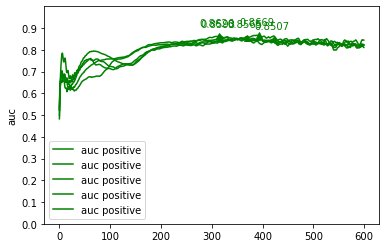

In [42]:
class Discriminator(nn.Module):
    def __init__(self, n_hidden):
        super(Discriminator, self).__init__()
        self.bilinear = nn.Bilinear(n_hidden, n_hidden, 1)
        for m in self.modules():
            self.weights_init(m)

    def weights_init(self, m):
        if isinstance(m, nn.Bilinear):
            torch.nn.init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.fill_(0.0)

    def forward(self, features, summary):
        s = self.bilinear(features, summary)
        return s

# class DiscriminatorCos(nn.Module):
#     def __init__(self):
#         super(DiscriminatorCos, self).__init__()
#         self.cos = torch.nn.CosineSimilarity(dim=1, eps=1e-06)
# 
#     def forward(self, features, summary):
#         print(features.shape)
#         print(summary.shape)
#         s = self.cos(features, summary)
#         
#         return torch.unsqueeze(s, 0)
    
class GraphLocalGraphPooling(nn.Module):
    def __init__(self, g, n_hop):
        # TODO: Simulate random walk (randomly drop some subgraph)
        super(GraphLocalGraphPooling, self).__init__()
        A = g.adjacency_matrix().to_dense() 
        A = A + torch.eye(A.shape[0])
        A_n = A
        for i in range(n_hop):
            A_n =  torch.matmul(A_n, A)
        # TODO: Check matrix situation (sym, factor
        A = torch.sign(A_n)
        self.A = torch.matmul(torch.diag(1/torch.sum(A, dim=1)), A)
        self.A = self.A.cuda()
    def forward(self, feature):
        # feature: [n_nodes, n_features]
        feature = torch.matmul(self.A, feature)
        return feature


class GGD_Anomaly(nn.Module):
    def __init__(self, g, in_feats, n_hidden, n_layers, activation, dropout, proj_layers, gnn_encoder, num_hop, subgraph_size):
        super(GGD_Anomaly, self).__init__()
        self.g = g
        self.encoder = Encoder(g, in_feats, n_hidden, n_layers, activation, dropout, gnn_encoder, num_hop)
        self.discriminator = Discriminator(n_hidden)
        # self.discriminator = DiscriminatorCos()
        self.graph_average_pooling = lambda x: x
        if subgraph_size > 0:
            self.graph_average_pooling = GraphLocalGraphPooling(g, subgraph_size)
        
        self.graph_conv_layers = self.encoder.conv.layers
        self.mlp = torch.nn.ModuleList()
        self.dropout = torch.nn.Dropout(0.2)
        for i in range(proj_layers):
            self.mlp.append(nn.Linear(n_hidden, n_hidden))
        # GGD
        self.lin = nn.Linear(n_hidden, n_hidden)
    def forward(self, features):
        features = self.dropout(features)
        embedding_node = features
        for i, graph_conv_layer in enumerate(self.graph_conv_layers):
             embedding_node = graph_conv_layer._activation(torch.matmul(embedding_node, graph_conv_layer.weight) + graph_conv_layer.bias)


        embedding_graph_pos = self.encoder(features)
        # avg pooling 
        embedding_graph_readout = self.graph_average_pooling(embedding_node)
        # Add skip connection
        embedding_graph_proj = (embedding_graph_pos + embedding_graph_readout) / 2
        # Positive branch of Anomaly
        predicted_score_pos = self.discriminator(embedding_node, embedding_graph_proj)
        # change shape from [n_nodes, 1] to [1, n_nodes]
        predicted_score_pos = torch.swapaxes(predicted_score_pos, 0, 1)
        
        # Negative branch of Anomaly
        perm = torch.randperm(self.g.number_of_nodes())
        embedding_node_neg = embedding_node[perm]
        predicted_score_neg = self.discriminator(embedding_node_neg, embedding_graph_proj)
        predicted_score_neg = torch.swapaxes(predicted_score_neg, 0, 1)
        
        # ggd 
        ggd_score_pos = self.lin(embedding_graph_proj).sum(1).unsqueeze(0)
        
        embedding_graph_neg = self.encoder(features[perm])
        ggd_score_neg = self.lin(embedding_graph_neg).sum(1).unsqueeze(0)
        return predicted_score_pos, predicted_score_neg, ggd_score_pos, ggd_score_neg
g = g.to(device)
# Create GGD model

gamma = 0.07

for i in range(5):
    ggd = GGD_Anomaly(
        g,
        ft_size,
        args.n_hidden,
        args.n_layers,
        nn.PReLU(args.n_hidden),
        args.dropout,
        args.proj_layers,
        args.gnn_encoder,
        args.num_hop,
        args.subgraph_size
    )
    if args.cuda:
        ggd.cuda()
    
    #%%
    
    
    ggd_optimizer = torch.optim.Adam(ggd.parameters(),
                                     lr=args.ggd_lr,
                                     weight_decay=args.weight_decay)
    b_xent = nn.BCEWithLogitsLoss()
    
    #%% md
    
    # train GGD
    
    #%%
    
    cnt_wait = 0
    best = 1e9
    best_t = 0
    counts = 0
    avg_time = 0
    dur = []
    loss_list = []
    
    tag = str(datetime.datetime.now().strftime("%m-%d %H%M%S"))
    # print("Memory beg:", torch.cuda.memory_allocated(device) / 1024 / 1024)
    
    epoch_list = []
    auc_score_list = []
    auc_pos_list = []
    auc_neg_list = []
    pos_std = []
    neg_std = []
    score_std = []
    label_positive = torch.zeros(1, g.number_of_nodes()).cuda()
    label_negative = torch.ones(1, g.number_of_nodes()).cuda()
    with tqdm(total=args.n_ggd_epochs) as pbar:
        pbar.set_description('Training')
        for epoch in range(args.n_ggd_epochs):
            if epoch % args.eval_freq == 0:
                ggd.eval()
                with torch.no_grad():
                    pos_prob_list = []
                    neg_prob_list = []
                    # for i in range(args.auc_test_rounds):
                    #     feature_dropout = aug_feature_dropout(features, 0.2)
                    #     pos_prob_list.append(ggd(feature_dropout).detach()[0])
                    #     perm = torch.randperm(g.number_of_nodes())
                    #     inverse_perm = torch.argsort(perm)
                    #     features_perm = feature_dropout[perm]
                    #     neg_prob_list.append(ggd(features_perm).detach()[0][inverse_perm])
                    pos_prob_list.append(ggd(features)[0].detach()[0])
                    # perm = torch.randperm(g.number_of_nodes())
                    # inverse_perm = torch.argsort(perm)
                    # features_perm = features[perm]
                    # neg_prob_list.append(ggd(features_perm).detach()[0])
                    # neg_prob_list.append(ggd(features_perm).detach()[0][inverse_perm])
                    
                    pos_prob = torch.mean(torch.stack(pos_prob_list), axis=0)
                    # neg_prob = torch.mean(torch.stack(neg_prob_list), axis=0)
                    # ano_score = (neg_prob - pos_prob).cpu().numpy()
                    epoch_list.append(epoch)
                    # auc_score_list.append(roc_auc_score(ano_label, ano_score))
                    auc_pos_list.append(roc_auc_score(ano_label, pos_prob.cpu().numpy()))
                    # auc_neg_list.append(roc_auc_score(ano_label, neg_prob.cpu().numpy()))
                    pos_std.append(np.std(pos_prob.cpu().numpy()))
                    # neg_std.append(np.std(neg_prob.cpu().numpy()))
                    # score_std.append(np.std(ano_score))
            
            t0 = time.time()
            ggd.train()
            if epoch >= 3:
                t0 = time.time()
                
            ggd_optimizer.zero_grad()
            # Positive
            # training_features = aug_feature_dropout(features, drop_percent=0.2)
            training_features = features
            s_positive, s_negative, ggd_score_pos, ggd_score_neg = ggd(training_features)
            loss_positive = b_xent(s_positive, label_positive)
            loss_negative = b_xent(s_negative, label_negative)
            loss_anomaly = loss_positive + loss_negative
            loss_ggd = b_xent(ggd_score_pos, label_positive) + b_xent(ggd_score_neg, label_negative)
            loss = (1-gamma) * loss_anomaly + gamma * loss_ggd
            
            loss.backward()
            ggd_optimizer.step()
        
            comp_time = time.time() - t0
            if loss < best:
                best = loss
                best_t = epoch
                cnt_wait = 0
                # torch.save(ggd.state_dict(), 'checkpoints_ggd/best_ggd' + tag + '.pkl')
            else:
                cnt_wait += 1
        
            if cnt_wait == args.patience:
                print('Early stopping!')
                break
        
            if epoch >= 3:
                dur.append(time.time() - t0)
            
            pbar.set_postfix(loss=loss.item())
            pbar.update(1)
            loss_list.append((loss.detach().cpu().item(), loss_positive.detach().cpu().item(), loss_negative.detach().cpu().item()))
            avg_time += comp_time
            counts += 1
    
    
    #%% md
    
    # Visualization
    
    #%%
    
    def draw_line(plt, epoch_list, data_list, color, label, max_marker=None):
        plt.plot(epoch_list, data_list, color=color, label=label)
        if max_marker is not None:
            max_index = np.argmax(data_list)
            val_str = "{:.4f}".format(data_list[max_index])
            plt.plot(epoch_list[max_index],data_list[max_index], color=color, marker=max_marker)
            plt.annotate(val_str,xytext=(-20, 10), textcoords='offset points',
                xy=(epoch_list[max_index],data_list[max_index]), color=color)
        
    import matplotlib.pyplot as plt
    # draw_line(plt, epoch_list, auc_score_list, 'r', label="auc negative - positive", max_marker="^")
    draw_line(plt, epoch_list, auc_pos_list, 'g', label="auc positive", max_marker="^")
    # draw_line(plt, epoch_list, auc_neg_list, 'b', label="auc negative", max_marker="^")
    
    
    plt.ylabel('auc')
    plt.legend()
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1, step=0.1))
    plt.savefig("aggdv2.png", dpi=400)
    
    #%%
    
    print(max(auc_pos_list))
    
    #%%
    
    